# Vision in FRC 

We're going to go over the basic process of using computer vision in FRC contexts to compute location of a target relative to your robot.

The `%matplotlib inline` magic will allow Jupyter to display plots inline. 

In [1]:
%matplotlib inline

/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


These lines import OpenCV (`cv2`) and pyplot (as `plt` for short)

In [2]:
import cv2
import matplotlib.pyplot as plt

## Steps

1. Acquire Image
2. Locate Target
3. Determine Pose Change

## Acquire Image

Now that we have loaded some useful libraries let's actually use them. Since Step 1 is acquiring an image we're going to do just that. You'll notice there's a folder of images located at [images](images/), let's look at a simple one: 

<img src="images/14_00_640.png" />

Let's learn how to load that so OpenCV can find the target.

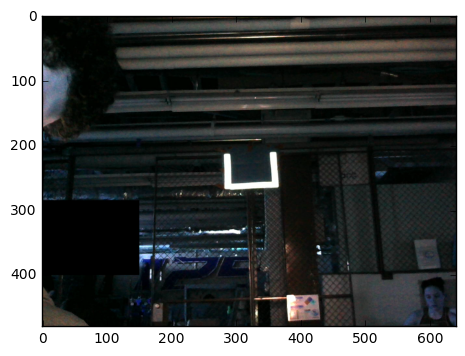

In [5]:
image = cv2.imread("images/14_00_640.png")
plt.imshow(image)

You can see that the image is in fact 640x480 pixels and we can see the target we want is located at about (325, 250) so we should expect whatever processing pipeline we want to make to spit out those numbers. 

## Locate Target

This is the part that gets tricky. It's all about transforming the image such that the target is highly visible and not much else is. We're going to try a few things and then discuss some tricks for finding a pipeline that works. 

### Just Threshold

Optimally, what we want is to get an image that the target is white and everything else is black, why? Because the `findContours` function operates on binary images. So, let's see how close we can get without doing anything more than a threshold operation.

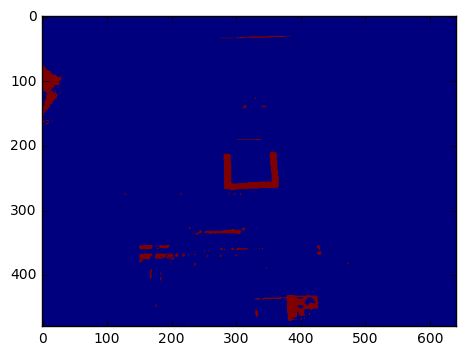

In [6]:
imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
plt.imshow(thresh)